# Example Pyllelic Use-Case Notebook

## Background

This notebook illustrates the import and use of `pyllelic` in a jupyter environment.

See https://github.com/Paradoxdruid/pyllelic for further details.

## Set-up

In [1]:
import pyllelic

In [2]:
# set up your disk location:
# base_path should be the directory we'll do our work in
# make a sub-directory under base_path with a folder named "test"
# and put the .bam and .bai files in "test"

pyllelic.set_up_env_variables(
    base_path="/Users/abonham/documents/test_allelic/",
    prom_file="TERT-promoter-genomic-sequence.txt",
    prom_start="1293000",
    prom_end="1296000",
    chrom="5",
)

## Main Parsing Functions

In [3]:
files_set = pyllelic.make_list_of_bam_files()  # finds bam files

In [4]:
# Uncomment for debugging:
# files_set

In [5]:
# index bam and creates bam_output folders/files
positions = pyllelic.index_and_fetch(files_set)

In [6]:
pyllelic.genome_parsing()

In [7]:
cell_types = pyllelic.extract_cell_types(files_set)

In [8]:
# Uncomment for debugging
# cell_types

In [9]:
# Set filename to whatever you want
df_list = pyllelic.run_quma_and_compile_list_of_df(cell_types, "tester2.xlsx", run_quma=False) # to skip quma: , run_quma=False)

In [10]:
# Uncomment for debugging
# df_list.keys()

In [11]:
means = pyllelic.process_means(df_list, positions, files_set)

In [12]:
# Uncomment for debugging
# means

In [13]:
modes = pyllelic.process_modes(df_list, positions, files_set)

In [14]:
# Uncomment for debugging
# modes

In [15]:
diff = pyllelic.find_diffs(means, modes)

In [16]:
# Uncomment for debugging
# diff

## Write Output to excel files

In [17]:
# Set the filename to whatever you want
pyllelic.write_means_modes_diffs(means, modes, diff, "Test_Output")

## Visualizing Data

In [18]:
final_data = pyllelic.pd.read_excel(pyllelic.config.base_directory.joinpath("Test_Output_diff.xlsx"),
        dtype=str,
        index_col=0,
)

In [19]:
final_data

,1293104,1293139,1293561,1293588,1293690,1293730,1294004,1294031,1294196,1294223,...,1295393,1295430,1295590,1295680,1295743,1295770,1295876,1295903,1295937,1295979
fh_NCIH196_LUNG.TERT.bam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.0471976401179941,0,0.2253521126760563,NaN,-0.09890109890109888,0,NaN,0
fh_CALU1_LUNG.TERT.bam,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0,NaN,...,NaN,NaN,0,0,0,NaN,0,0,NaN,NaN


In [20]:
individual_data = pyllelic.return_individual_data(df_list, positions, files_set)

In [21]:
individual_data.loc['fh_NCIH196_LUNG.TERT.bam']

1293104                                                  NaN
1293139                                                  NaN
1293561                                                  NaN
1293588                                                  NaN
1293690                                                  NaN
1293730                                                  NaN
1294004                                                  NaN
1294031                                                  NaN
1294196                                                  NaN
1294223                                                  NaN
1294235                                                  NaN
1294262                                                  NaN
1294316                                                  NaN
1294343                                                  NaN
1294369                                                  NaN
1294419    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1294446                 

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

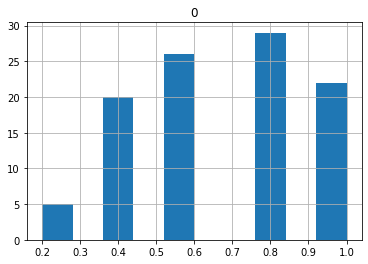

In [23]:
pyllelic.histogram(individual_data, 'fh_NCIH196_LUNG.TERT.bam', '1294945')